# First Attempt with Keras

Let's have a play around and see what I can do. Let's just build a nice simple model, using the medium article as a follow along. 

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import StandardScaler, MinMaxScaler
min_max = MinMaxScaler()
scaler = StandardScaler()

DOWNLOAD_DIR = Path('../download')

In [56]:
sns.set()

In [57]:
price = pd.read_csv(DOWNLOAD_DIR / 'price.csv')
close = price.loc[:, 'c']

In [58]:
price.head()

,timestamp,c,h,l,o
0,2010-07-17T23:00:00Z,0.04951,0.04951,0.04951,0.04951
1,2010-07-18T00:00:00Z,NaN,NaN,NaN,NaN
2,2010-07-18T01:00:00Z,NaN,NaN,NaN,NaN
3,2010-07-18T02:00:00Z,NaN,NaN,NaN,NaN
4,2010-07-18T03:00:00Z,0.05941,0.05941,0.05941,0.05941


In [59]:
close.tail()

92969    47437.266848
92970    47332.765754
92971    47410.123970
92972    45889.364858
92973    47467.739097
Name: c, dtype: float64

Let's take 1 year of data and use it to predict the next 30 days. 

In [60]:
prediction_days = 30
one_year = 365
# close[-365 - 2*30:].plot()

close_train = close[(-one_year - 2 * prediction_days) : -2 * prediction_days] # [-365 - 60 : -60]
close_val = close[-2 * prediction_days: -prediction_days] # [-60 : -30]
close_test = close[-prediction_days:] # [-30:]

<AxesSubplot:>

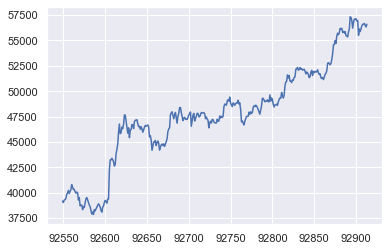

In [50]:
close_train.plot()

<AxesSubplot:>

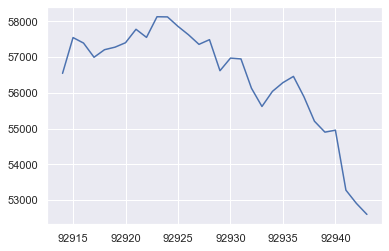

In [51]:
close_val.plot()

<AxesSubplot:>

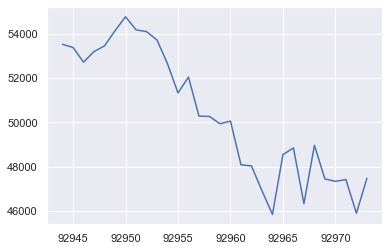

In [52]:
close_test.plot()

In [28]:
close_train.index[-1], close_test.index[0]

(92943, 92944)

In [53]:
close_train.shape

(365,)

In [61]:
# Prep for training
training_set = close_train.values.reshape(-1, 1)
training_set = min_max.fit_transform(training_set)
training_set = training_set.reshape((-1, 1, 1))

validation_set = close_val.values.reshape(-1, 1)
validation_set = min_max.transform(validation_set)
validation_set = validation_set.reshape((-1, 1, 1))

# Prep for testing
testing_set = close_test.values.reshape((-1, 1))
testing_set = min_max.transform(testing_set)
testing_set = testing_set.reshape((-1, 1, 1))

# We are training to predict the next day's close
# so cut off final val for X_train and start at index 1 for
# y_train
X_train = training_set[:-1]
y_train = training_set[1:]

X_val = validation_set[:-1]
y_val = validation_set[1:]

X_test = testing_set[:-1]
y_test = testing_set[1:]

In [62]:
from tensorflow.keras.metrics import RootMeanSquaredError

regressor = Sequential([
    LSTM(4),
    Dense(1)
])
regressor.compile(optimizer='adam', 
                  loss='mse',
                  metrics=[RootMeanSquaredError()])

history = regressor.fit(X_train, 
                        y_train, 
                        batch_size=5, 
                        epochs=100,
                        shuffle=False,
                        validation_data=(X_val, y_val))

Train on 364 samples, validate on 29 samples
Epoch 1/100
364/364 [==============================] - 5s 13ms/sample - loss: 0.1535 - root_mean_squared_error: 0.3917 - val_loss: 0.3875 - val_root_mean_squared_error: 0.6225
Epoch 2/100
364/364 [==============================] - 0s 930us/sample - loss: 0.0685 - root_mean_squared_error: 0.2618 - val_loss: 0.2199 - val_root_mean_squared_error: 0.4690
Epoch 3/100
364/364 [==============================] - 0s 947us/sample - loss: 0.0336 - root_mean_squared_error: 0.1832 - val_loss: 0.1264 - val_root_mean_squared_error: 0.3556
Epoch 4/100
364/364 [==============================] - 0s 998us/sample - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0827 - val_root_mean_squared_error: 0.2877
Epoch 5/100
364/364 [==============================] - 0s 1ms/sample - loss: 0.0226 - root_mean_squared_error: 0.1504 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2513
Epoch 6/100
364/364 [==============================] - 0s 977us/sample - 

364/364 [==============================] - 0s 975us/sample - loss: 4.7207e-04 - root_mean_squared_error: 0.0217 - val_loss: 7.8489e-04 - val_root_mean_squared_error: 0.0280
Epoch 47/100
364/364 [==============================] - 0s 990us/sample - loss: 4.7112e-04 - root_mean_squared_error: 0.0217 - val_loss: 7.8360e-04 - val_root_mean_squared_error: 0.0280
Epoch 48/100
364/364 [==============================] - 0s 997us/sample - loss: 4.7019e-04 - root_mean_squared_error: 0.0217 - val_loss: 7.8263e-04 - val_root_mean_squared_error: 0.0280
Epoch 49/100
364/364 [==============================] - 0s 1ms/sample - loss: 4.6928e-04 - root_mean_squared_error: 0.0217 - val_loss: 7.8196e-04 - val_root_mean_squared_error: 0.0280
Epoch 50/100
364/364 [==============================] - 0s 993us/sample - loss: 4.6840e-04 - root_mean_squared_error: 0.0216 - val_loss: 7.8155e-04 - val_root_mean_squared_error: 0.0280
Epoch 51/100
364/364 [==============================] - 0s 999us/sample - loss: 4.675

364/364 [==============================] - 0s 927us/sample - loss: 4.6616e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1631e-04 - val_root_mean_squared_error: 0.0286
Epoch 91/100
364/364 [==============================] - 0s 883us/sample - loss: 4.6636e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1715e-04 - val_root_mean_squared_error: 0.0286
Epoch 92/100
364/364 [==============================] - 0s 889us/sample - loss: 4.6656e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1797e-04 - val_root_mean_squared_error: 0.0286
Epoch 93/100
364/364 [==============================] - 0s 872us/sample - loss: 4.6676e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1876e-04 - val_root_mean_squared_error: 0.0286
Epoch 94/100
364/364 [==============================] - 0s 831us/sample - loss: 4.6694e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1953e-04 - val_root_mean_squared_error: 0.0286
Epoch 95/100
364/364 [==============================] - 0s 846us/sample - loss: 4.6

In [18]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

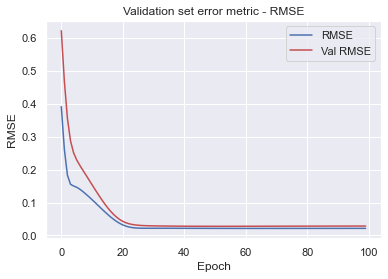

In [67]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

fig, ax = plt.subplots()
plt.plot(rmse, 'b', label='RMSE')
plt.plot(val_rmse, 'r', label='Val RMSE')
ax.set(xlabel='Epoch', ylabel='RMSE',
      title='Validation set error metric - RMSE')
# plt.yticks([0, .1, .2, .3, .4])
plt.legend()
plt.show()

In [68]:
# Smallest rmse
min(val_rmse), np.argmin(val_rmse)

(0.02795342, 50)

In [84]:
val_rmse[-1]

0.028698

~3% of max change in dataset. We think this is not very good. A 3% price change is significant. Hard to interpret. 

In [70]:
# Smallest loss
min(val_loss), np.argmin(val_loss)

(0.0007813936611236041, 50)

In [83]:
history.history['val_root_mean_squared_error'][-1]

0.028698

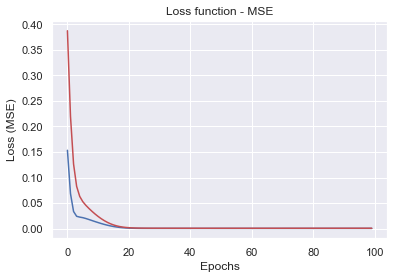

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots()
plt.plot(loss, 'b', label='Loss (MSE)')
plt.plot(val_loss, 'r', label='Val Loss (MSE)')
ax.set(xlabel='Epochs', ylabel='Loss (MSE)',
      title='Loss function - MSE')
plt.show()

In [73]:
predicted_price = regressor.predict(X_test)
predicted_price = min_max.inverse_transform(predicted_price)

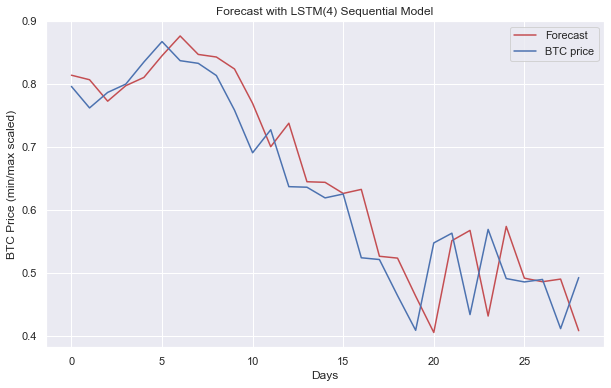

In [78]:
# Need to inverse transform to get correct y-axis values
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(regressor.predict(X_test), 'r', label='Forecast')
plt.plot(np.ravel(y_test), 'b', label='BTC price')
plt.legend()
ax.set(xlabel='Days', ylabel='BTC Price (min/max scaled)',
      title='Forecast with LSTM(4) Sequential Model')
plt.show()

This is expected (from a model doing a very bad job). Trained on bull data and validated on bear data. 

In [76]:
# Loss for this model
rmse_class = RootMeanSquaredError()
rmse_class(y_test, regressor.predict(X_test)).numpy()

0.06531364

In [80]:
# WHY IS THIS DIFFERENT TO THE VALIDATION_RMSE????
rmse_class(y_val, regressor.predict(X_val)).numpy()

0.05044525

In [81]:
rmse_class(y_train, regressor.predict(X_train)).numpy()

0.027286403